<a href="https://colab.research.google.com/github/ndb796/PyTorch-CNN/blob/main/PyTorch_CNN_MNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **MNIST Dataset**

* 작성자: 나동빈(Dongbin Na)
* 본 코드는 POSTECH의 **CSED703G 수업** 과제로 작성한 코드입니다.
* CNN을 이용해 MNIST 데이터셋에 대하여 학습/평가를 진행합니다.
* 코드 실행 전에 **[런타임]** → **[런타임 유형 변경]** → 유형을 **GPU**로 설정해야 합니다.

#### 필요한 라이브러리 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import os

device = 'cuda'

#### 데이터셋(Dataset) 다운로드 및 불러오기

In [2]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

#### 학습(Training) 및 평가(Testing) 함수 정의

In [3]:
def train(net, epoch, optimizer, criterion, train_loader):
    print('[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)


def evaluate(net, epoch, file_name, data_loader, info):
    print('[ Evaluate epoch: %d ]' % epoch)
    print("Dataset:", info)

    net.eval() # Dropout을 적용하는 경우 필수임
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        test_loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', test_loss / total)
    return (100. * correct / total, test_loss / total)

#### 혼동행렬(Confusion Matrix) 함수 정의

* 학습이 완료된 모델을 불러와 혼동 행렬을 NumPy 객체로 반환합니다.
* 별도로 데이터 로더(data loader)를 파라미터로 이용해 해당 데이터셋에 대하여 평가를 진행합니다.

In [4]:
def get_confusion_matrix(net, num_classes, data_loader):
    confusion_matrix = torch.zeros(num_classes, num_classes)

    net.eval() # Dropout을 적용하는 경우 필수임

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

#### LeNet 모델 정의

* **과제에서 명시하고** 있는 LeNet 모델 아키텍처는 다음과 같습니다.
  * PyTorch가 공식적으로 제공하는 LeNet 아키텍처와 차이가 있습니다.
* PyTorch 공식 LeNet 코드를 참고하여 아래 아키텍처에 맞게 변형했습니다.

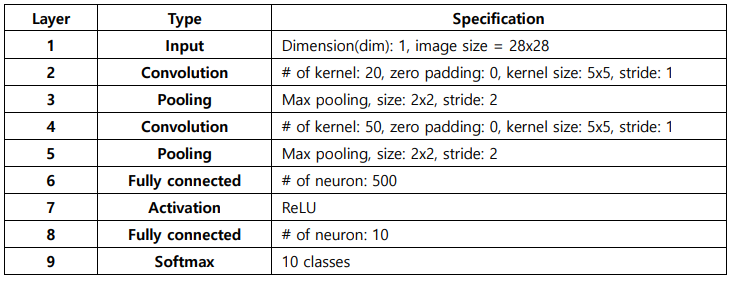

In [5]:
class LeNet(nn.Module):
    # 실제로 가중치가 존재하는 레이어만 객체로 만들기
    def __init__(self):
        super(LeNet, self).__init__()
        # 여기에서 (1 x 28 x 28)
        # 입력 채널: 1, 출력 채널: 20 (커널 20개)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=0)
        # 여기에서 (20 x 24 x 24)
        # 풀링 이후에 (20 x 12 x 12)
        # 입력 채널: 20, 출력 채널: 50 (커널 20개)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=0)
        # 여기에서 (50 x 8 x 8)
        # 풀링 이후에 (50 x 4 x 4)
        self.fc1 = nn.Linear(50 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), (2, 2))
        x = F.max_pool2d(self.conv2(x), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # 3차원의 컨볼루션 레이어를 flatten
    def num_flat_features(self, x):
        size = x.size()[1:] # 배치는 제외하고
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

#### AlexNet 모델 정의

* **과제에서 명시하고** 있는 AlexNet 모델 아키텍처는 다음과 같습니다.
  * PyTorch가 공식적으로 제공하는 AlexNet 아키텍처와 차이가 있습니다.
* PyTorch 공식 AlexNet 코드를 참고하여 아래 아키텍처에 맞게 변형했습니다.

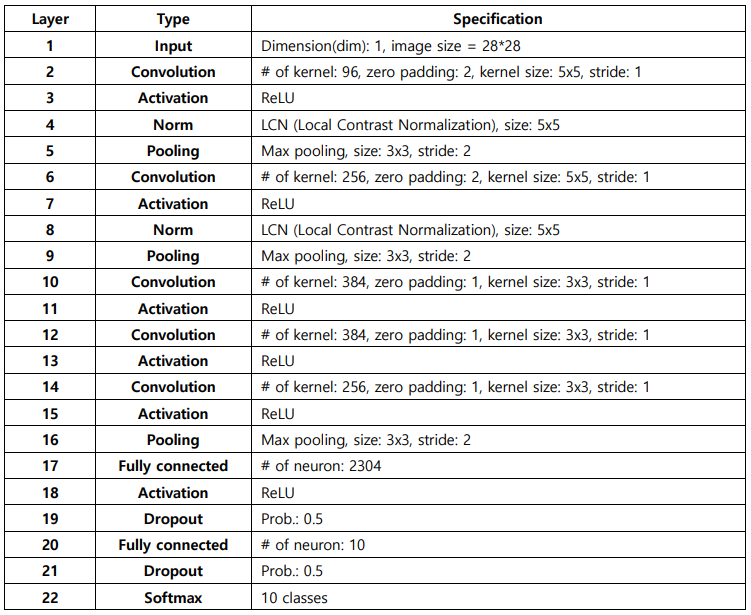

In [7]:
class LocalResponseNorm(nn.Module):
    def __init__(self, size, alpha = 1e-4, beta = 0.75, k = 1.0):
        super(LocalResponseNorm, self).__init__()
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.k = k

    def forward(self, input):
        return F.local_response_norm(input, self.size, self.alpha, self.beta, self.k)

In [8]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # 여기에서 (1 x 28 x 28)
            # 입력 채널: 1, 출력 채널: 96 (커널 96개)
            nn.Conv2d(1, 96, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            LocalResponseNorm(size=5),
            # 여기에서 (96 x 28 x 28)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (96 x 13 x 13)
            # 입력 채널: 96, 출력 채널: 256 (커널 256개)
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            LocalResponseNorm(size=5),
            # 여기에서 (256 x 13 x 13)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (256 x 6 x 6)
            # 입력 채널: 256, 출력 채널: 384 (커널 384개)
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 6 x 6)
            nn.ReLU(inplace=True),
            # 입력 채널: 384, 출력 채널: 384 (커널 384개)
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 6 x 6)
            nn.ReLU(inplace=True),
            # 입력 채널: 384, 출력 채널: 384 (커널 384개)
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 6 x 6)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (384 x 2 x 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(384 * 2 * 2, 2304),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2304, 10),
            nn.Dropout(),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### 결과 확인: LeNet 결과 분석

In [9]:
net = LeNet()
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "LeNet_MNIST.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, test_loader, "Test"))

for i in range(epoch):
    train(net, i, optimizer, criterion, train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

[ Evaluate epoch: 0 ]
Dataset: Train
Accuarcy: 9.791666666666666
Average loss: 0.018025637725989023
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 10.1
Average loss: 0.023059978199005127
[ Train epoch: 0 ]
Train accuarcy: 88.11666666666666
Train average loss: 0.0033620998666932184
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 96.81833333333333
Average loss: 0.0008295834608686467
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 96.88
Average loss: 0.0009727075963746756
Model Saved!
[ Train epoch: 1 ]
Train accuarcy: 97.51833333333333
Train average loss: 0.0006310971893680593
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 98.22
Average loss: 0.000457598009519279
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 98.02
Average loss: 0.0005741962970001623
Model Saved!
[ Train epoch: 2 ]
Train accuarcy: 98.32166666666667
Train average loss: 0.00043391009023568283
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 98.57
Average loss: 0.0003580904897651635
[ Evaluate epoch: 3 ]
Dataset: Test
Accuarcy: 98

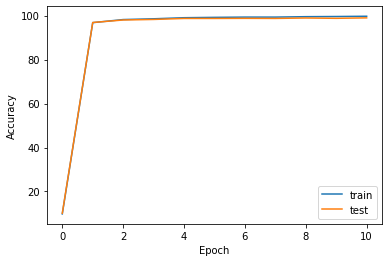

In [10]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

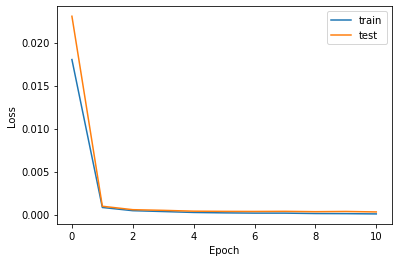

In [11]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851., 5949.])
[ 혼동 행렬(confusion matrix) 시각화 ]


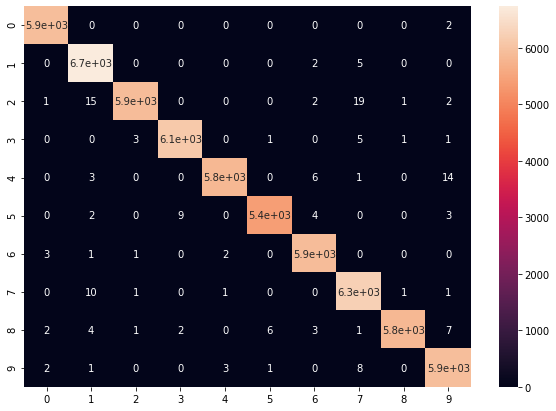

[ 각 클래스에 따른 정확도 ]
tensor([0.9997, 0.9990, 0.9933, 0.9982, 0.9959, 0.9967, 0.9988, 0.9978, 0.9956,
        0.9975])
[ 전체 평균 정확도 ]
tensor(0.9973)


In [12]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = LeNet()
net = net.to(device)

file_name = "./checkpoint/LeNet_MNIST.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

[ 각 클래스당 데이터 개수 ]
tensor([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974., 1009.])
[ 혼동 행렬(confusion matrix) 시각화 ]


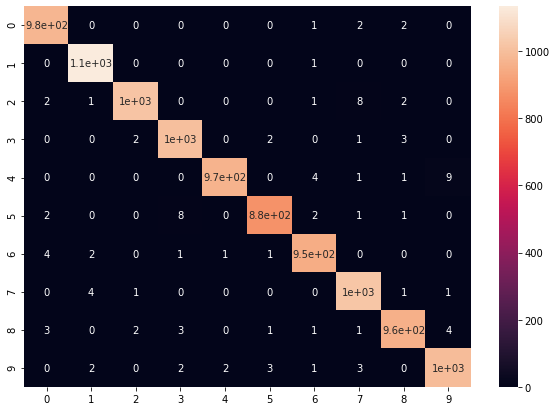

[ 각 클래스에 따른 정확도 ]
tensor([0.9949, 0.9991, 0.9864, 0.9921, 0.9847, 0.9843, 0.9906, 0.9932, 0.9846,
        0.9871])
[ 전체 평균 정확도 ]
tensor(0.9899)


In [13]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = LeNet()
net = net.to(device)

file_name = "./checkpoint/LeNet_MNIST.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### 결과 확인: AlexNet 결과 분석

In [14]:
net = AlexNet()
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "AlexNet_MNIST.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, test_loader, "Test"))

for i in range(epoch):
    train(net, i, optimizer, criterion, train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

[ Evaluate epoch: 0 ]
Dataset: Train
Accuarcy: 9.871666666666666
Average loss: 0.018002405579884848
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 9.8
Average loss: 0.02303129713535309
[ Train epoch: 0 ]
Train accuarcy: 41.42666666666667
Train average loss: 0.01189205967883269
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 95.61333333333333
Average loss: 0.0012426629186297457
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 96.11
Average loss: 0.0014188698723912238
Model Saved!
[ Train epoch: 1 ]
Train accuarcy: 58.64666666666667
Train average loss: 0.007143481730421384
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 97.88
Average loss: 0.0006185126607306301
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 98.21
Average loss: 0.0006799515148624778
Model Saved!
[ Train epoch: 2 ]
Train accuarcy: 58.74333333333333
Train average loss: 0.006980481933554014
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 98.39166666666667
Average loss: 0.00047190706393060585
[ Evaluate epoch: 3 ]
Dataset: Test
Accua

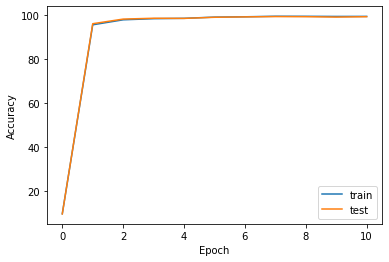

In [15]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

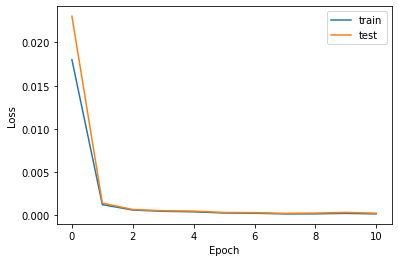

In [16]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851., 5949.])
[ 혼동 행렬(confusion matrix) 시각화 ]


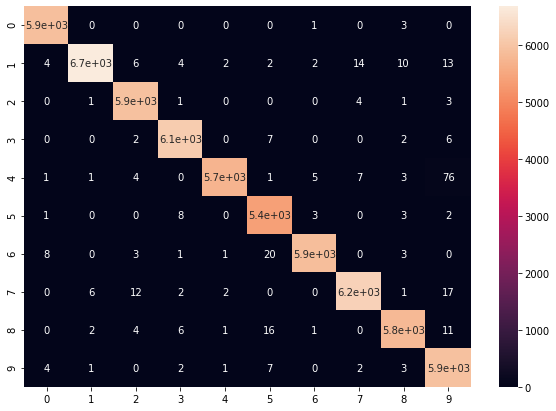

[ 각 클래스에 따른 정확도 ]
tensor([0.9993, 0.9915, 0.9983, 0.9972, 0.9832, 0.9969, 0.9939, 0.9936, 0.9930,
        0.9966])
[ 전체 평균 정확도 ]
tensor(0.9943)


In [17]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = AlexNet()
net = net.to(device)

file_name = "./checkpoint/AlexNet_MNIST.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

[ 각 클래스당 데이터 개수 ]
tensor([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974., 1009.])
[ 혼동 행렬(confusion matrix) 시각화 ]


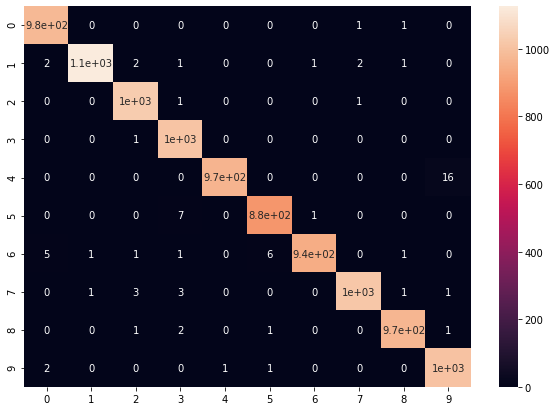

[ 각 클래스에 따른 정확도 ]
tensor([0.9980, 0.9921, 0.9981, 0.9990, 0.9837, 0.9910, 0.9843, 0.9912, 0.9949,
        0.9960])
[ 전체 평균 정확도 ]
tensor(0.9929)


In [18]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = AlexNet()
net = net.to(device)

file_name = "./checkpoint/AlexNet_MNIST.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### 결과 확인: ImageNet Pretrained ResNet을 활용한 Transfer learning  결과 분석

In [19]:
# 사전 학습된 모델의 경우 입력 데이터의 크기가 224 x 224이므로, MNIST 데이터셋의 크기를 조절할 필요가 있음
transfer_transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

transfer_transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

transfer_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transfer_transform_train)
transfer_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transfer_transform_test)

transfer_train_loader = torch.utils.data.DataLoader(transfer_train_dataset, batch_size=128, shuffle=True, num_workers=4)
transfer_test_loader = torch.utils.data.DataLoader(transfer_test_dataset, batch_size=100, shuffle=False, num_workers=4)

In [20]:
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "Transfer_Learning_MNIST.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, transfer_train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, transfer_test_loader, "Test"))

for i in range(epoch):
    train(net, i, optimizer, criterion, transfer_train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, transfer_train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, transfer_test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

[ Evaluate epoch: 0 ]
Dataset: Train
Accuarcy: 10.496666666666666
Average loss: 0.0192571338613828
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 10.38
Average loss: 0.02461892282962799
[ Train epoch: 0 ]
Train accuarcy: 98.02
Train average loss: 0.0005476541460918573
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 99.535
Average loss: 0.00012781603547239986
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 99.33
Average loss: 0.00022198352547420655
Model Saved!
[ Train epoch: 1 ]
Train accuarcy: 99.65833333333333
Train average loss: 9.267403066526944e-05
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 99.83666666666667
Average loss: 5.193480314774206e-05
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 99.53
Average loss: 0.0001453047541574051
Model Saved!
[ Train epoch: 2 ]
Train accuarcy: 99.805
Train average loss: 5.532751899542442e-05
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 99.925
Average loss: 2.4572361676352253e-05
[ Evaluate epoch: 3 ]
Dataset: Test
Accuarcy: 99.52
Average loss: 0

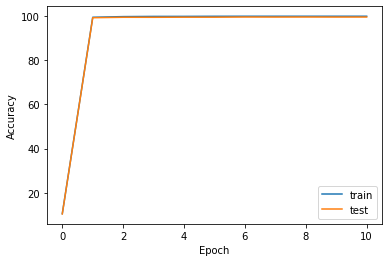

In [24]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

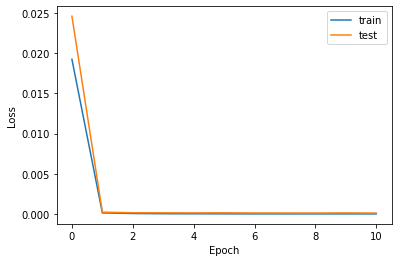

In [25]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851., 5949.])
[ 혼동 행렬(confusion matrix) 시각화 ]


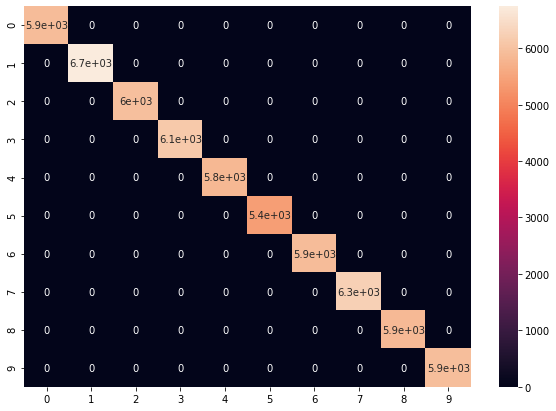

[ 각 클래스에 따른 정확도 ]
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
[ 전체 평균 정확도 ]
tensor(1.)


In [28]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_MNIST.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, transfer_train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

[ 각 클래스당 데이터 개수 ]
tensor([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974., 1009.])
[ 혼동 행렬(confusion matrix) 시각화 ]


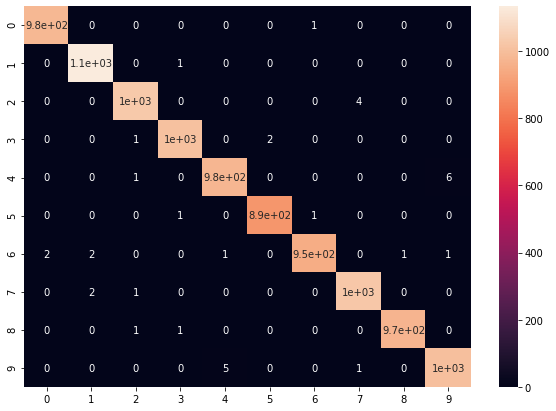

[ 각 클래스에 따른 정확도 ]
tensor([0.9990, 0.9991, 0.9961, 0.9970, 0.9929, 0.9978, 0.9927, 0.9971, 0.9979,
        0.9941])
[ 전체 평균 정확도 ]
tensor(0.9964)


In [29]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_MNIST.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, transfer_test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### 학습 이후에 학습된 모델 다운로드 하기

In [30]:
from google.colab import files

In [31]:
files.download("./checkpoint/LeNet_MNIST.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
files.download("./checkpoint/AlexNet_MNIST.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
files.download("./checkpoint/Transfer_Learning_MNIST.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>